### Урок 7. #Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях#

Программа урока:

1. Теоретическая часть:
    - Проблема интерпретируемости моделей
    - Примеры, когда это важно
    - Обзор методов

2. Практическая часть:
    - Feature importance, доступный в самих моделях
    - Permutation Importance
    - SHAP

На уроке будет затронут важный для любого бизнеса, применяющего машинное обучение при решении задач, аспект - интерпретируемость моделей. Т.е важно не только умение обучать модели, которые делают качественные прогнозы, но и умение объяснить эти прогнозы. Когда мы не просто понимаем, что пользователь склонен совершить некоторое действие (например, уйти в отток), но и можем выявить факторы, влияющие на это, что позволяет скорректировать стратегию взаимодействия с пользователями (как пример). Такая модель может быть полезна не только своими прогнозами, но и инсайтами, которые скрыты в данных. 

### Проблема интерпретируемости моделей машинного обучения

Интерпретируемость – это возможность объяснить прогнозы модели на понятном бизнесу языке

Черный ящик (так часто видят ML)

![ab_split](blackbox.png "blackbox ML")

Особенности:

1. мы получаем прогнозы, которые приносят пользу (ну, должны)
2. мы не можем внятно объяснить почему прогнозы именно такие и что именно повлияло на принятие решения модели

![ab_split](blackbox2.png "blackbox ML + inter")

Интерпретация прогнозов модели может дать интересные инсайты о том, какая у нас аудитория (вспоминаем uplift-моделирование)

Иногда же на практике интерпретируемость является критичным моментом

Как выглядит процесс: 

1. есть реальный мир
2. мы векторизуем его (как можем - получаем признаки)
3. строим модель
4. интерпретируем
5. объясняем людям поведение модели


![ab_split](inter2.png "inter1")

![ab_split](inter1.png "inter1")

* картинка взята с https://habr.com/ru/company/otus/blog/464695/

### Обзор методов

- важные признаки в модели (feature importance)
- влияние каждого отдельного признака на конкретный прогноз 
- влияние каждого признака на большое количество возможных прогнозов (топ k наблюдений, например)

### 1. Feature importance признаков

Пример с линейной моделью

Набор данных взят отсюда - https://www.kaggle.com/harlfoxem/housesalesprediction

In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
df = pd.read_csv("kc_house_data.csv")
print(df.shape)
df.head(3)

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


В качестве предикторов (признаков) будем использовать 4 - bedrooms, sqft_living, sqft_lot и yr_built

Целевая переменная - price (цена)

In [24]:
features = ["bedrooms", "sqft_living", "sqft_lot", "yr_built"]
target = "price"

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

Соберем пайплайн

In [25]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

    
continuous_columns = ["bedrooms", "yr_built", 'sqft_living', 'sqft_lot']
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Модель - линейная регрессия

In [26]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', LinearRegression()),
])

In [27]:
#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bedrooms',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='bedrooms')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('yr_built',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='yr_built')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('sqft_living',
                                                 Pipeline(steps=[('selector',
                         

Посчитаем MAE и коэффициент детерминации (R2)

In [28]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(162462.49573861933, 0.5365765901167386)

mae малоинформативен, но вот r2 - очень понятен.

На случай, если кто забыл:

![r2](r2.png "R2 score")

Интерпретация:

1. принимает значения от -1 до 1. Чем ближе к 1, тем лучше модель объясняет данные (соответствует модели данных)
2. значение 1 означает функциональную зависимость y от X
3. В общем случае коэффициент детерминации может быть и отрицательным, это говорит о крайней неадекватности модели: простое среднее приближает лучше

источник на вики - https://ru.wikipedia.org/wiki/Коэффициент_детерминации

Наконец, давайте посмотрим на "важность" признаков (в линейной регрессии это просто веса (коэффициенты) при предикторах (признаках)

Сразу же возьмем абсолютные значения коэффициентов

In [29]:
intercept = regressor[1].intercept_
features = pd.DataFrame(regressor[1].coef_, 
                        continuous_columns, 
                        columns=['coefficient'])
features.head()

,coefficient
bedrooms,-55705.016661
yr_built,-71039.334129
sqft_living,316113.766523
sqft_lot,-14820.959494


Как это можно интерпретировать:

1. sqft_living имеет наибольшую важность и положителен (чем выше жилая площадь, тем выше стоимость)
2. остальные признаки уже идут с отрицательным весом
3. вторым по важности признаком является год постройки (yr_built)

### Перейдем к "деревянным" моделям

In [30]:
import xgboost as xgb

In [9]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBRegressor()),
])

#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bedrooms',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='bedrooms')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('yr_built',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='yr_built')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('sqft_living',
                                                 Pipeline(steps=[('selector',
                         

In [31]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(162462.49573861933, 0.5365765901167386)

In [32]:
xgb_features = pd.DataFrame(regressor[1].feature_importances_, 
                        continuous_columns, 
                        columns=['coefficient'])
xgb_features.head()

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

Как можно считать feature_importance в моделях на базе деревьев решений

![xgboost](xgboost_tree.png "Xgboost tree")

Ссылка (рекомендую поизучать на досуге) - https://xgboost.readthedocs.io/en/latest/tutorials/model.html

Существует несколько вариантов как для признака в деревьях решений посчитать важность

1. Gain - показывает относительный вклад каждой фичи в модель. 
Алгоритм простой - идем по каждому дереву, смотрим в каждом узле дерева по какому признаку происходит разбиение узла и насколько снижаетcя неопределенность (gini impurity, information gain). Далее для каждого признака суммируется её вклад (по всем деревьям)

2. Frequency - показывает, как часто конкретный признак встречается в узлах дерева, то есть считается суммарное количество разбиений дерева на узлы для каждого признака в каждом дереве.

<b>Вопрос:</b>
Какие еще вы знаете модели со "встроенной" возможностью определять важность признаков?

Ваш ответ:

#### Краткий вывод:

Подходы, основанные на feature_importance, очень удобны, т.к по факту мы получаем готовый функционал и можем хоть какую-то интерпретацию давать без каких-либо внешних инструментов.

Однако проблема такого подхода заключается в том, что непонятно, как именно данная фича влияет на итоговый прогноз. 

Пример: жилая площадь важна для прогноза стоимости жилья, но как именно это может быть связано с другими признаками? Это будет в пункте 3, а сейчас давайте рассмотрим еще один (из множества) способ расчета "важности" признаков

### 2. Permutation importance

Алгоритм очень простой:

- обучаем модель на тренировочном наборе данных
- проверяем качество на валидации
- для валидационного набора данных перемешиваем один из признаков
- снова проверяем качество на нем же

Признак считается «важным», если качество модели падает при его перемешивании.

Очень удобно, что в sklearn есть возможность из коробки такое делать

In [33]:
from sklearn.inspection import permutation_importance
r = permutation_importance(regressor, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

Пример как это может выглядеть на выходе

In [34]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{continuous_columns[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

yr_built 1.427 +/- 0.031
sqft_lot 0.074 +/- 0.004
bedrooms 0.046 +/- 0.002
sqft_living 0.004 +/- 0.001


Интересно, что результаты немного другие, нежели при использовании "встроенного" feature_importances_)

https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

### SHAP

ссылка на проект - https://github.com/slundberg/shap

Wiki - https://en.wikipedia.org/wiki/Shapley_value

Значения Шэпли пришли к нам из теории игр.

Пример - группа людей (далее - коалиция) играет в игру. 

Необходимо распределить призовой фонд между ними в зависимости от их вклада.

Уточнения (допущения):

- игроки с равным вкладом должны получить одинаковую награду
- если вклад игрока нулевой, то награда также нулевая
- если игрок провел несколько игр, то его награда - это сумма наград за каждую из игр

Немного математики (ссылка - https://en.wikipedia.org/wiki/Shapley_value)

![shap2](shap2.png "SHAP 1")

u - это выигрыш команды

n - количество игроков

S - коалиция (подмножество из n без игрока i)

А теперь попробуем "переложить" все это на вариант с задачей обучения с учителем

- игра - результат обучения с учителем (на основе заданного примера)
#- выигрыш – это разница между матожиданием результата на всех имеющихся примерах и результатом, полученном на заданном примере
- вклады игроков в игру – влияние каждого значения признака на выигрыш, т.е. результат.

Значение Шэпли для i-той фичи рассчитывается для каждого сэмпла данных (каждого наблюдения) на всех возможных комбинациях фичей (включая отсутствие всех фичей), затем полученные значения суммируются по модулю и получается итоговая важность i-той фичи.

Расчет SHAP values очень тяжелый и затратный как по времени так и по ресурсам!

![ab_split](shap1.png "SHAP 1")

SHAP расшифровывается как SHapley Additive explanation. Этот метод помогает разбить на части прогноз, чтобы выявить значение каждого признака. 

Он основан на Векторе Шепли - принципе, используемом в теории игр для определения, насколько каждый игрок при совместной игре способствует ее успешному исходу (https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80). 

### ПЕРЕРЫВ до 20:55 (МСК)

### Игрушечный пример 

ссылка - https://arxiv.org/pdf/1802.03888.pdf

![shap4](shap4.png "SHAP 4")

На выходе для комбинации {Fever=Yes, Cough=Yes} хотим получить значимость признаков (т.е для конкретного наблюдения). 

Посчитаем выход модели для каждой возможной комбинации признаков:

![shap4](shap3.png "SHAP 3")

Теперь посчитаем SHAP для признака Fever для модели А (левое дерево).

Для этого посчитаем все необходимое для комбинаций признаков, которые не включают Fever:
![shap4](shap5.png "SHAP 5")

таких у нас 2:
![shap4](shap6.png "SHAP 6")

Подставляем значения в формулу и получаем SHAP для признака Fever:

![shap7](shap7.png "SHAP 7")

А теперь для признака Cough:

![shap8](shap8.png "SHAP 8")

Для модели B (дерево справа) получаем такое:

![shap9](shap9.png "SHAP 9")

Получаем значимость признаков на уровне одного примера с конкретными значениями признаков. 

* phi_0 - ожидаемый результат (для первой модели мы можем попасть в один из 4 листьев - ответ 20, для второй - 25)
* phi - ответ модели для конкретного наблюдения ({Fever=True, Cough=True}) - для первой модели 80, для второй - 90

### Пример (данные оттока с 5 занятия)

In [35]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

ModuleNotFoundError: No module named 'shap'

In [36]:
df = pd.read_csv("churn_data.csv")
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [37]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Exited'], random_state=0)

In [38]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

NameError: name 'shap' is not defined

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). 

- Цвет точки - это значение признака
- То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
- То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад

In [39]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

NameError: name 'shap' is not defined

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать интересные выводы и проверить их адекватность:
- чем старше человек, тем выше вероятность ухода
- чем признак IsActiveMember выше, то вероятность ухода ниже
- чем выше баланс, тем выше вероятность ухода (?)

Можно даже просто взять средние значения SHAP для каждого признака

In [40]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

NameError: name 'shap' is not defined

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

Feature selection:

1. RFE - recursive feature elimination (есть в sklearn)
2. Boruta - shadow features
3. Target permutation 

Домашнее задание к уроку №7

Использовала данный датасет - https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Цель классификации - предсказать, будет ли клиент подписываться (да/нет) на срочный депозит (переменная y).

сделать обзорный анализ выбранного датасета

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('bank-full.csv', delimiter=';')
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Информация о наборе данных:

Данные связаны с прямыми маркетинговыми кампаниями португальского банковского учреждения. Маркетинговые кампании основаны на телефонных звонках. Часто для того, чтобы получить доступ к продукту (банковский срочный депозит), необходимо было связаться с одним и тем же клиентом, если клиент согласится на продукт (банковский срочный депозит) ("да") или не согласится ("нет") на подписку.

bank-full.csv со всеми примерами и 17 признаками, упорядоченными по дате (старая версия этого набора данных с меньшим количеством признаков).

Цель классификации - предсказать, будет ли клиент подписываться (да/нет) на срочный депозит (переменная y).

Attribute Information:

Input variables:

bank client data:

1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'tertiary','secondary','unknown','primary')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - balance: (numeric)
7 - housing: has housing loan? (categorical: 'no','yes','unknown')
8 - loan: has personal loan? (categorical: 'no','yes','unknown')

related with the last contact of the current campaign:

9 - contact: contact communication type (categorical: 'cellular','telephone')
10 - day: (numeric)
11 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
12 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
other attributes:

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
15 - previous: number of contacts performed before this campaign and for this client (numeric)
16 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
17 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [3]:
df.shape

(45211, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
# Числовые переменные
num_vars = df.select_dtypes(include=['int64'])

# Категориальные переменные
cat_vars = [i for i in df.columns if i not in num_vars]
cat_vars.remove('y')
target = 'y'

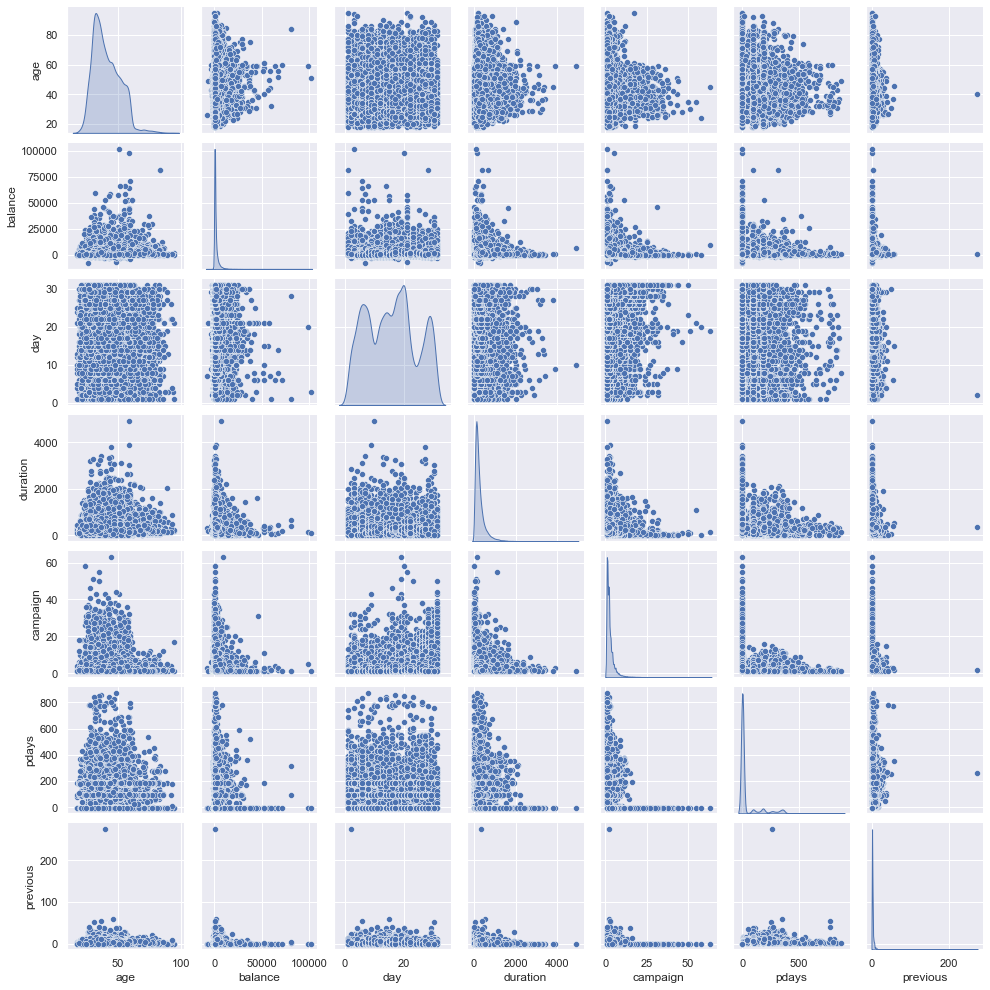

In [7]:
sns.set()
columns = [
    "age",
    "balance",
    "day",
    "duration",
    "campaign",
    "pdays",
    "previous"
]

sns.pairplot(df[columns], height=2, kind="scatter", diag_kind="kde")
plt.show()

Categorical Variable: job


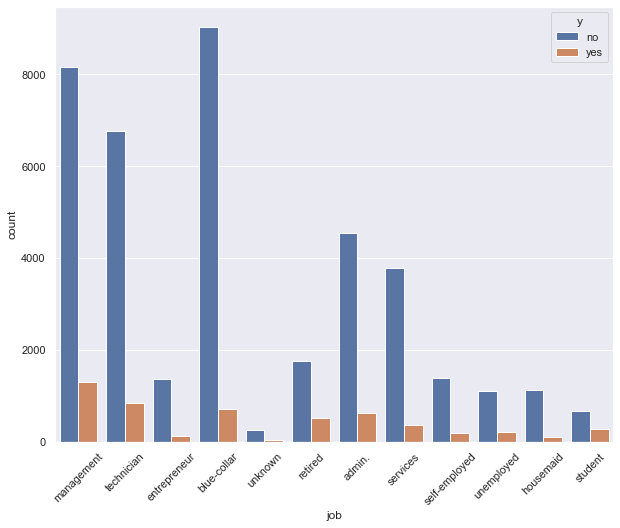

Categorical Variable: marital


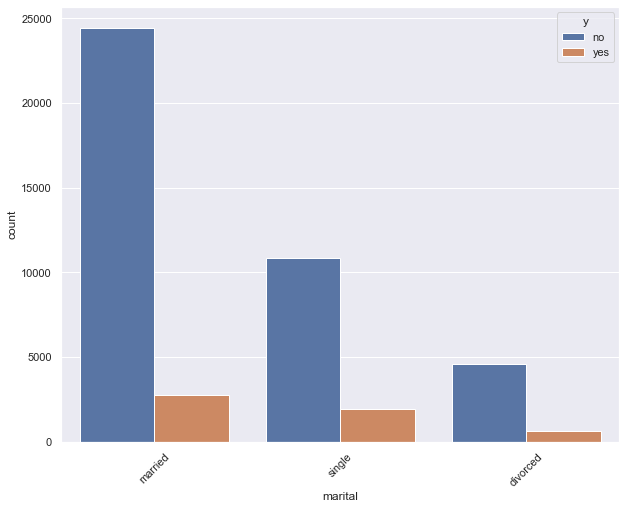

Categorical Variable: education


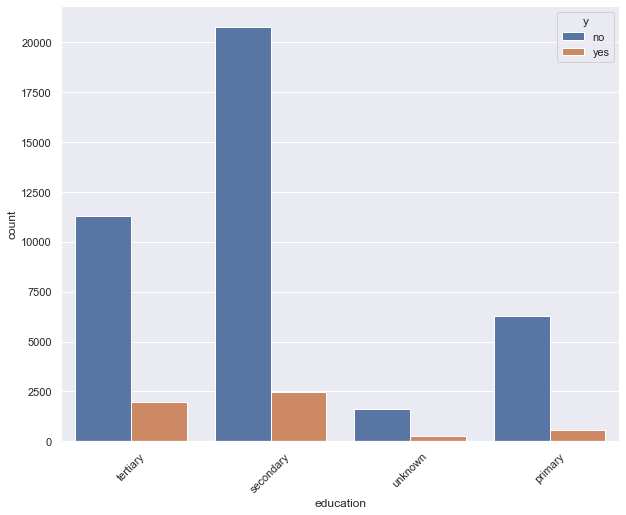

Categorical Variable: default


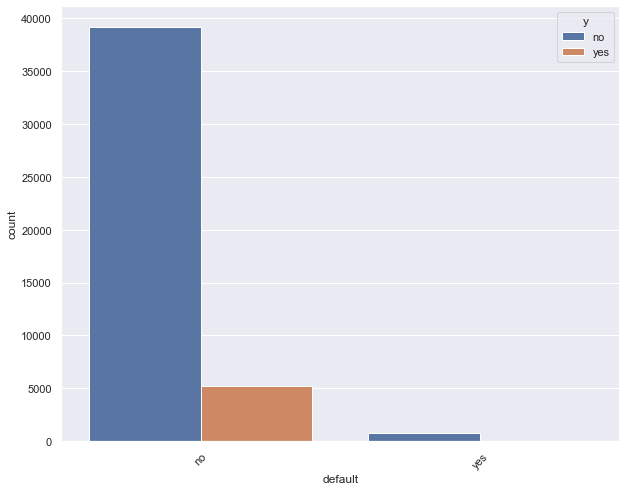

Categorical Variable: housing


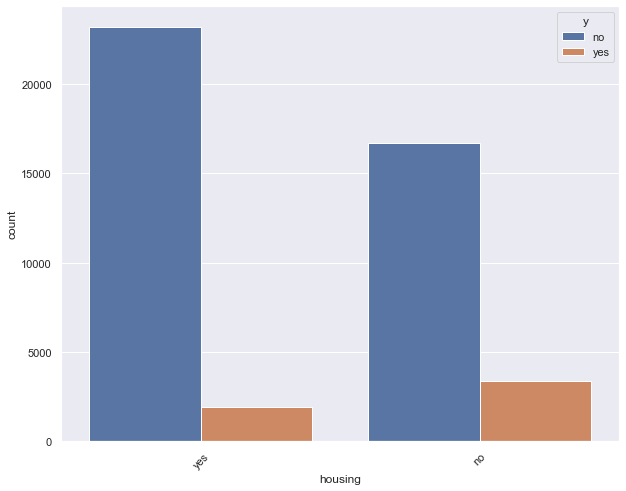

Categorical Variable: loan


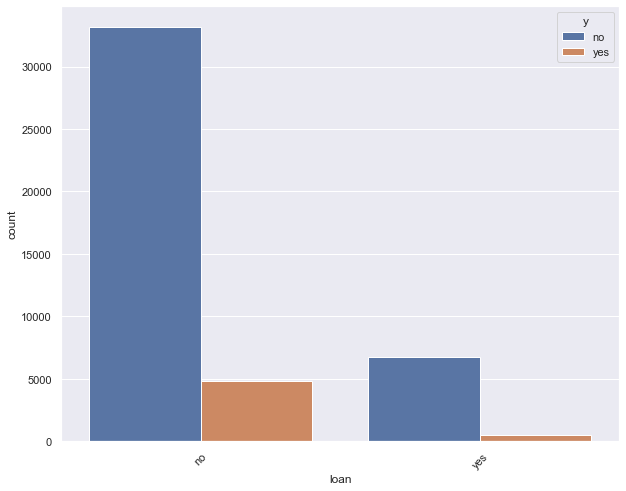

Categorical Variable: contact


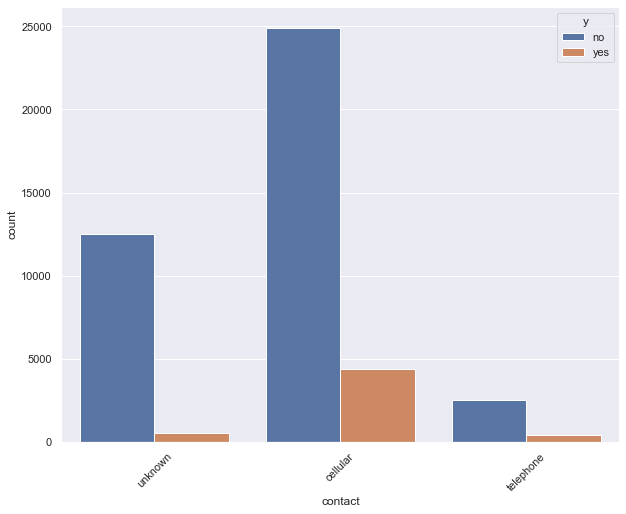

Categorical Variable: month


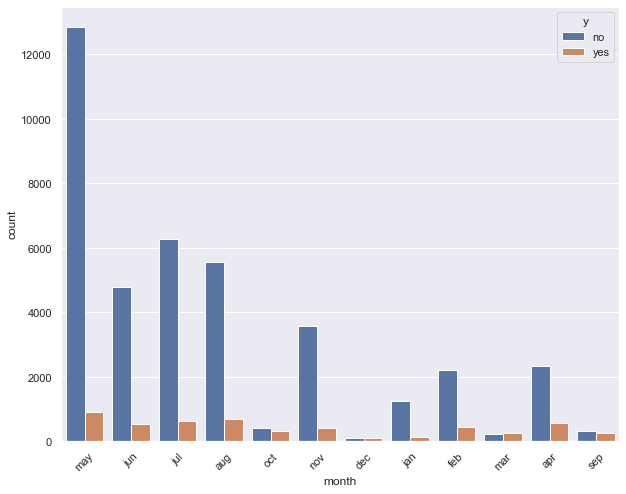

Categorical Variable: poutcome


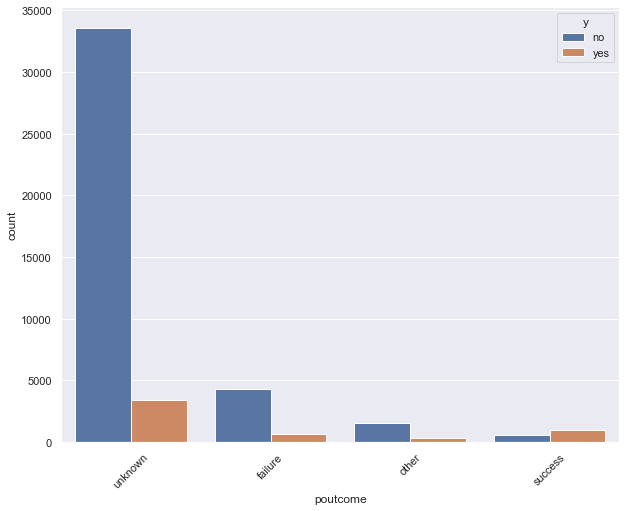

In [8]:
# Посмотрим на категориальные признаки
for cat_var in cat_vars:
    print("Categorical Variable: {}".format(cat_var))
    plt.figure(figsize=(10,8))
    sns.countplot(x=cat_var, hue=target, data=df)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    plt.show()

In [9]:
# Поменяем категориальные признаки 
for cat_col in cat_vars:
    df[cat_col] = df[cat_col].astype('category')

In [10]:
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  int8  
 2   marital    45211 non-null  int8  
 3   education  45211 non-null  int8  
 4   default    45211 non-null  int8  
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  int8  
 7   loan       45211 non-null  int8  
 8   contact    45211 non-null  int8  
 9   day        45211 non-null  int64 
 10  month      45211 non-null  int8  
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  int8  
 16  y          45211 non-null  object
dtypes: int64(7), int8(9), object(1)
memory usage: 3.1+ MB


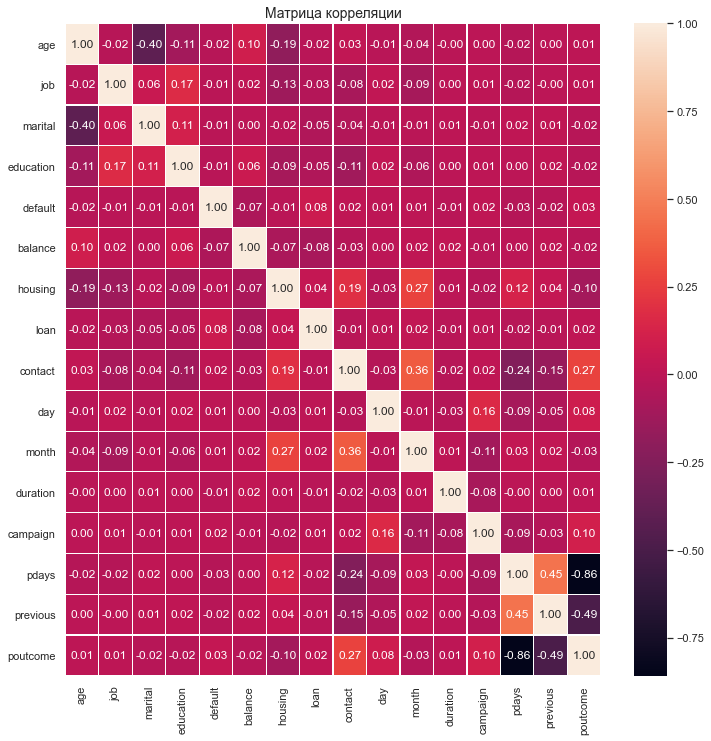

In [12]:
df_corr = df.drop('y', 1).corr()
f, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(df_corr, annot=True, linewidths=0.1, fmt='.2f', ax=ax)
            
plt.title('Матрица корреляции', size=14)
plt.show()

In [13]:
# Изменение целевой переменной
df['y'] = df['y'].map({'no': 0, 'yes': 1})

Обучить любой классификатор (какой вам нравится)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('y', 1), df['y'], random_state=42)

In [15]:
X_train.shape

(33908, 16)

In [16]:
y_train.shape

(33908,)

In [17]:
import xgboost as xgb

In [18]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
y_predict_proba = model.predict_proba(X_test)[:, 1]

[00:19:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [19]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [20]:
precision, recall, thresholds = precision_recall_curve(y_test, y_predict)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_true=y_test, y_score=y_predict)

Best Threshold=1.000, F-Score=0.551, Precision=0.645, Recall=0.480


Разобраться с SHAP и построить важности признаков

In [45]:
pip install shap

  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
Note: you may need to restart the kernel to use updated packages.


In [46]:
import shap
# load JS visualization code to notebook
shap.initjs()

всего тестового набора данных (summary_plot - дать интерпретацию)

In [47]:
model = xgb.train({"learning_rate": 0.01}, 
                      xgb.DMatrix(X_train, label=y_train), 100)

# строим модель объЯсненияе в SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# покажем объяснение первого примера (берем matplotlib=True для обхода Javascript)
shap.initjs() # для работы в колаборатории 
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

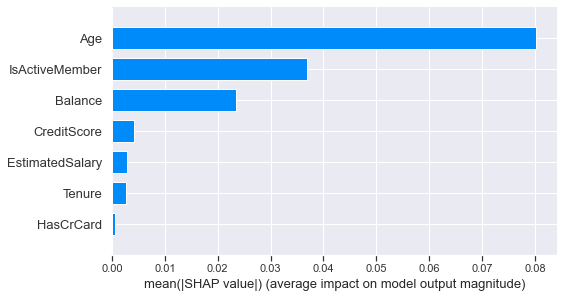

In [48]:
shap.summary_plot(shap_values=shap_values, features=X_test, plot_type='bar', max_display=10)

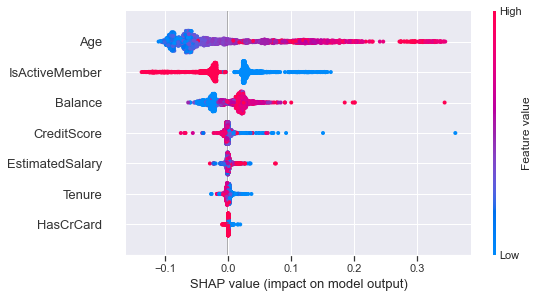

In [49]:
shap.summary_plot(shap_values, X_test)

для топ 10%

In [52]:
preds = y_predict_proba
X_test_10 = X_test
#Подсчитал модуль разницы между y_test и предсказанными значениями
dif = np.abs(y_test - preds).reset_index(drop=True)
X_test_10['dif'] = dif
length_10 = round(len(X_test_10) * 0.1)
#отсортировал по этому модулю и взял 10% значений с минимальной разницей
X_test_10 = X_test_10.sort_values(by=['dif']).iloc[: length_10, :]
X_test_10 = X_test_10.drop('dif', 1)

ValueError: operands could not be broadcast together with shapes (2500,) (11303,) 

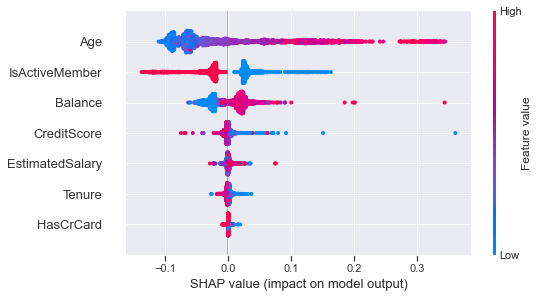

In [53]:
shap_values = explainer.shap_values(X_test_10)
shap.summary_plot(shap_values, X_test_10)

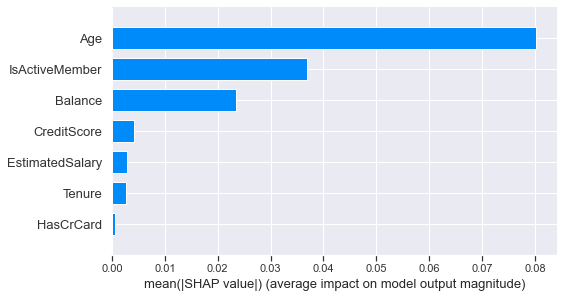

In [54]:
shap.summary_plot(shap_values=shap_values, features=X_test_10, plot_type='bar', max_display=10)

для отдельных наблюдений вывести force_plot

In [55]:
def force_plot(sample_number):
    display(
        pd.DataFrame(df.iloc[sample_number, :]).T,
        shap.force_plot(explainer.expected_value, shap_values[sample_number, :], X_train.iloc[sample_number, :]))

In [56]:
force_plot(sample_number=42)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
42,43,15687946,Osborne,556,France,Female,61,2,117419.35,1,1,1,94153.83,0
